# 影评分类：二分类问题示例
数据为50000条严重两极分化的评论。其中25000条用于训练评论，另外25000条用于测试评论。

In [1]:
from tensorflow.keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

num_words参数表示仅保留训练数据中前10000个最常出现的单词，低频词将被舍弃。没有这个限制，要处理训练数据中的88585个单词，许多单词只出现在一个样本中，对于分类是没有意义的。

In [2]:
# 把评论解码为文本
# word_index是一个将单词映射为整数索引的字典
word_index = imdb.get_word_index()
# 把字典的键和值交换，将整数索引映射为单词
reverse_word_index = dict(
    [(value, key) for (value, key) in word_index.items()])
# 对评论解码。索引减去了3，因为0、1、2是为其他词汇保留的索引
decoded_review = "".join(
    [reverse_word_index.get(i - 3, "?") for i in train_data[0]])

## 准备数据
神经网络处理的是大小相同的数据批量，需要把列表转换为张量。不能将整数列表传入神经网络

In [3]:
# 用multi-hot编码对整数序列进行编码
import numpy as np
def vectorize_sequences(sequences, dimension=10000):
    # 创建一个形状为(len(sequence), dimension)的零矩阵
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, j] = 1.
    return results

#把训练、测试数据向量化
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [4]:
# 把标签向量化
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

## 构建模型
输入数据是向量，标签是1和0的标量。带有relu激活函数的密集连接层的简单堆叠在这一类问题上，表现很好。
对于Dense层的堆叠，需要做出两个关键决策
- 神经网络有多少层
- 每层有多少个单元


In [5]:
from tensorflow import keras
from tensorflow.keras import layers

# 两个隐藏层，每层16个单元。第三层输出一个标量预测值，表示当前评论的情感类别
model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

## 编译模型
需要选择损失函数和优化器。二分类问题，使用binary_crossentropy损失函数，优化器使用rmsprop。
> 吴恩达的课程中提到，优化器使用Adam，Chollet在书中认为，rmsprop对于所有问题，都是很好的默认选择。可能我理解上有差异，这两个是用在不同地方的东西。


In [6]:
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

## 验证模型
深度学习模型不应该在训练数据上进行评估，标准做法是使用验证集来监控训练过程中的模型精度。
* 从原始数据中留出10000个样本作为验证集。
* 使用由512个样本组成的小批量，对模型训练20轮。
* 通过validation_data参数传入验证数据，监控在留出的10000个样本上的损失和精度。

In [7]:
# 留出验证集
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

In [8]:
# 训练模型
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20


2024-06-24 20:58:26.476963: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


30/30 [==============================] - 1s 27ms/step - loss: 0.5070 - accuracy: 0.7838 - val_loss: 0.4082 - val_accuracy: 0.8288
Epoch 2/20
30/30 [==============================] - 0s 15ms/step - loss: 0.2994 - accuracy: 0.9064 - val_loss: 0.3184 - val_accuracy: 0.8775
Epoch 3/20
30/30 [==============================] - 0s 8ms/step - loss: 0.2220 - accuracy: 0.9270 - val_loss: 0.2830 - val_accuracy: 0.8876
Epoch 4/20
30/30 [==============================] - 0s 15ms/step - loss: 0.1751 - accuracy: 0.9426 - val_loss: 0.2787 - val_accuracy: 0.8884
Epoch 5/20
30/30 [==============================] - 0s 16ms/step - loss: 0.1408 - accuracy: 0.9575 - val_loss: 0.2829 - val_accuracy: 0.8855
Epoch 6/20
30/30 [==============================] - 0s 15ms/step - loss: 0.1185 - accuracy: 0.9645 - val_loss: 0.3074 - val_accuracy: 0.8795
Epoch 7/20
30/30 [==============================] - 0s 14ms/step - loss: 0.0952 - accuracy: 0.9727 - val_loss: 0.3170 - val_accuracy: 0.8829
Epoch 8/20
30/30 [=======

## 绘制训练损失和验证损失的图表
会发现有趣的东西

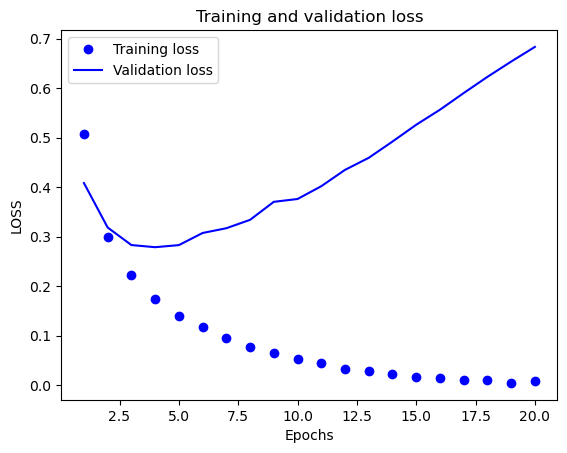

In [9]:
import matplotlib.pyplot as plt 
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("LOSS")
plt.legend()
plt.show()

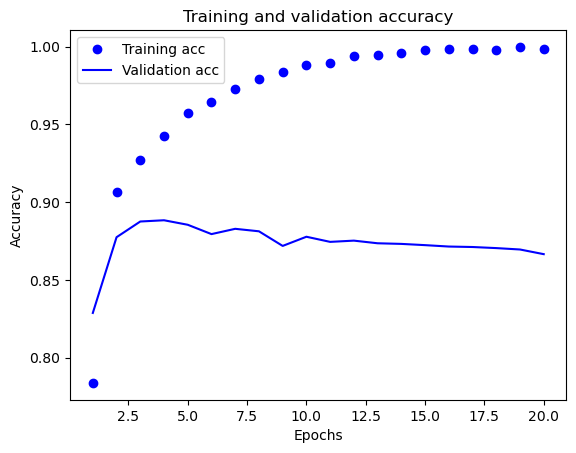

In [10]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

通过绘制图表，我们直观的发现，训练次数增加后，验证损失和验证精度并没有一直改善————出现了过拟合。
为了防止过拟合，我们在4轮后停止训练。再从头训练一个模型，训练4轮，然后在测试数据上评估模型

In [11]:
model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.fit(x_train, y_train, epochs=4, batch_size=512)
results=model.evaluate(x_test, y_test)

Epoch 1/4
49/49 [==============================] - 1s 8ms/step - loss: 0.4541 - accuracy: 0.8286
Epoch 2/4
49/49 [==============================] - 0s 5ms/step - loss: 0.2661 - accuracy: 0.9087
Epoch 3/4
49/49 [==============================] - 0s 8ms/step - loss: 0.2034 - accuracy: 0.9286
Epoch 4/4
782/782 [==============================] - 1s 628us/step - loss: 0.2974 - accuracy: 0.8814


In [12]:
model.predict(x_test)

782/782 [==============================] - 1s 713us/step


array([[0.19449459],
       [0.99967116],
       [0.66914135],
       ...,
       [0.08137473],
       [0.06876944],
       [0.4973342 ]], dtype=float32)

# 改一下

In [15]:
# 使用3个隐藏层
model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.fit(x_train, y_train, epochs=4, batch_size=512)
results=model.evaluate(x_test, y_test)
results

Epoch 1/4
49/49 [==============================] - 1s 7ms/step - loss: 0.4653 - accuracy: 0.8110
Epoch 2/4
49/49 [==============================] - 0s 5ms/step - loss: 0.2538 - accuracy: 0.9106
Epoch 3/4
49/49 [==============================] - 0s 5ms/step - loss: 0.1948 - accuracy: 0.9294
Epoch 4/4
782/782 [==============================] - 1s 697us/step - loss: 0.3378 - accuracy: 0.8704


[0.337824285030365, 0.8703600168228149]

In [16]:
# 使用1个隐藏层
model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.fit(x_train, y_train, epochs=4, batch_size=512)
results=model.evaluate(x_test, y_test)
results

Epoch 1/4
49/49 [==============================] - 1s 9ms/step - loss: 0.4397 - accuracy: 0.8300
Epoch 2/4
49/49 [==============================] - 0s 6ms/step - loss: 0.2702 - accuracy: 0.9093
Epoch 3/4
49/49 [==============================] - 0s 6ms/step - loss: 0.2149 - accuracy: 0.9258
Epoch 4/4
782/782 [==============================] - 1s 585us/step - loss: 0.2807 - accuracy: 0.8866


[0.28073590993881226, 0.8865600228309631]